In [27]:
import pandas as pd

users = pd.read_csv("users.csv")
subs = pd.read_csv("subscriptions.csv")
spend = pd.read_csv("marketing_spend.csv")

print("Users columns:", users.columns)
print("Subscriptions columns:", subs.columns)
print("Marketing spend columns:", spend.columns)

users.head()
subs.head()
spend.head()

Users columns: Index(['user_id', 'signup_date', 'acquisition_channel'], dtype='object')
Subscriptions columns: Index(['user_id', 'subscription_start_date', 'plan_type', 'monthly_price',
       'status'],
      dtype='object')
Marketing spend columns: Index(['date', 'channel', 'spend'], dtype='object')


,date,channel,spend
0,2025-01-01,Google,1912.03
1,2025-01-01,Meta,1358.07
2,2025-01-01,Organic,987.89
3,2025-01-01,Referral,1684.27
4,2025-01-01,Email,1843.77


In [28]:
subs["status"].unique()

array(['active', 'churned'], dtype=object)

In [29]:
import pandas as pd
import numpy as np

np.random.seed(42)

users = pd.read_csv("users.csv")
subs = pd.read_csv("subscriptions.csv")

subs = subs.merge(
    users[["user_id", "acquisition_channel", "signup_date"]],
    on="user_id",
    how="left"
)

subs["subscription_start_date"] = pd.to_datetime(subs["subscription_start_date"])
subs["signup_date"] = pd.to_datetime(subs["signup_date"])

In [30]:
churn_rate_by_channel = {
    "Google": 0.32,
    "Meta": 0.38,
    "Email": 0.28,
    "Organic": 0.16,
    "Referral": 0.12
}

subs["base_churn_p"] = subs["acquisition_channel"].map(churn_rate_by_channel).fillna(0.25)

In [31]:
end_date = subs["subscription_start_date"].max()
subs["tenure_days"] = (end_date - subs["subscription_start_date"]).dt.days

tenure_multiplier = np.where(subs["tenure_days"] <= 30, 1.35,
                    np.where(subs["tenure_days"] <= 90, 1.15, 0.90))

subs["churn_p"] = np.clip(subs["base_churn_p"] * tenure_multiplier, 0, 0.85)

In [32]:
rand = np.random.rand(len(subs))
subs["status"] = np.where(rand < subs["churn_p"], "churned", "active")

In [33]:
subs["status"].value_counts(normalize=True)
subs.groupby("acquisition_channel")["status"].apply(lambda s: (s == "churned").mean()).sort_values(ascending=False)

acquisition_channel
Meta        0.428896
Google      0.374315
Email       0.334356
Organic     0.184044
Referral    0.145608
Name: status, dtype: float64

In [34]:
subs_out = subs[["user_id", "subscription_start_date", "plan_type", "monthly_price", "status"]]
subs_out.to_csv("subscriptions.csv", index=False)

In [35]:
import sqlite3
import pandas as pd

# connect to database (creates file if not exists)
conn = sqlite3.connect("streaming_analytics.db")

# read tables
users = pd.read_csv("users.csv")
subs = pd.read_csv("subscriptions.csv")
spend = pd.read_csv("marketing_spend.csv")

# write to database
users.to_sql("users", conn, if_exists="replace", index=False)
subs.to_sql("subscriptions", conn, if_exists="replace", index=False)
spend.to_sql("marketing_spend", conn, if_exists="replace", index=False)

print("Tables loaded.")


Tables loaded.


In [36]:
query = """
SELECT acquisition_channel, COUNT(*) AS signups
FROM users
GROUP BY acquisition_channel
ORDER BY signups DESC
"""

pd.read_sql_query(query, conn)


,acquisition_channel,signups
0,Google,10734
1,Meta,9064
2,Organic,8995
3,Referral,3698
4,Email,3509


In [37]:
query = """
SELECT acquisition_channel, COUNT(*) AS signups
FROM users
GROUP BY acquisition_channel
Order by signups DESC
"""

pd.read_sql_query(query, conn)

,acquisition_channel,signups
0,Google,10734
1,Meta,9064
2,Organic,8995
3,Referral,3698
4,Email,3509


In [38]:
query = """
SELECT users.acquisition_channel, COUNT(*) AS subscribers
FROM users
INNER JOIN subscriptions ON users.user_id = subscriptions.user_id
GROUP BY users.acquisition_channel
ORDER BY subscribers DESC
"""
pd.read_sql_query(query, conn)

,acquisition_channel,subscribers
0,Organic,2206
1,Google,1643
2,Meta,879
3,Referral,831
4,Email,652


In [39]:
query = """
SELECT u.acquisition_channel, COUNT(*) AS subscribers
FROM users u
JOIN subscriptions s ON u.user_id = s.user_id
GROUP BY u.acquisition_channel
ORder By subscribers DESC
"""
pd.read_sql_query(query, conn)

,acquisition_channel,subscribers
0,Organic,2206
1,Google,1643
2,Meta,879
3,Referral,831
4,Email,652


🧠 Problem 3

Write a SQL query that returns:

acquisition_channel

total_signups

total_subscribers

conversion_rate

Rules:

• Use ONE query

• You must join

• You must use COUNT properly

• conversion_rate must be decimal (not integer)

Hint:
If you divide two integers in SQL, you may get 0.
Force decimal.

In [40]:
query = """
SELECT u.acquisition_channel, COUNT(*) AS signups, SUM(CASE WHEN s.user_id is not null then 1 else 0 end) AS subscribers, 
(1.0 * SUM(CASE WHEN s.user_id is not null then 1 else 0 end) / COUNT(*)) AS conversion_rate
FROM users u
Left JOIN subscriptions s ON u.user_id = s.user_id
GROUP BY u.acquisition_channel
"""
pd.read_sql_query(query, conn)

,acquisition_channel,signups,subscribers,conversion_rate
0,Email,3509,652,0.185808
1,Google,10734,1643,0.153065
2,Meta,9064,879,0.096977
3,Organic,8995,2206,0.245247
4,Referral,3698,831,0.224716


Problem 4

Calculate CAC by acquisition_channel.

Definition:

CAC = total marketing spend / total subscribers

Rules:

Use ONE query

Join marketing_spend to users and subscriptions

Return acquisition_channel, spend, subscribers, CAC

CAC must be decimal

If a channel has 0 subscribers, CAC should be NULL (avoid divide by zero)

You need to figure out how to connect spend to channel.

Most likely marketing_spend has channel and date and spend.
You will aggregate spend by channel.
Then subscribers by channel.
Then compute CAC.

You can use WITH if you want, but you do not have to.
If you use it, it will be cleaner.

Write the SQL and run it.

Paste your query and output table.

In [41]:
query = """
SELECT acquisition_channel, SUM(CASE WHEN s.user_id is not null THEN 1 else 0 end) AS subscribers,
(SUM(m.spend) / SUM(CASE WHEN s.user_id is not null THEN 1 else 0 end)) AS CAC
FROM users u
JOIN subscriptions s ON u.user_id = s.user_id
JOIN marketing_spend m ON u.acquisition_channel = m.channel
GROUP BY acquisition_channel
"""

pd.read_sql_query(query, conn)

,acquisition_channel,subscribers,CAC
0,Email,78240,1241.000417
1,Google,197160,1334.373333
2,Meta,105480,1246.948333
3,Organic,264720,1284.175333
4,Referral,99720,1270.455667


In [42]:
query = """
SELECT acquisition_channel, SUM(spend) AS dollar
FROM users u
JOIN marketing_spend m ON u.acquisition_channel = m.channel
GROUP BY acquisition_channel
"""

pd.read_sql_query(query, conn)

,acquisition_channel,dollar
0,Email,5.225605e+08
1,Google,1.718780e+09
2,Meta,1.356281e+09
3,Organic,1.386139e+09
4,Referral,5.637774e+08


In [43]:
query = """
WITH user_base AS (
    SELECT
        u.user_id,
        u.acquisition_channel,
        CASE WHEN s.user_id IS NOT NULL THEN 1 ELSE 0 END AS converted,
        CASE WHEN s.status = 'active' THEN 1 ELSE 0 END AS active_sub
    FROM users u
    LEFT JOIN subscriptions s
        ON u.user_id = s.user_id
)

SELECT
    acquisition_channel,
    COUNT(user_id) AS total_signups,
    SUM(converted) AS total_subscribers,
    SUM(converted) * 1.0 / COUNT(user_id) AS conversion_rate,
    SUM(active_sub) AS active_subscribers,
    SUM(converted) - SUM(active_sub) AS churned_subscribers,
    SUM(active_sub) * 1.0 / SUM(converted) AS retention_rate,
    (SUM(converted) - SUM(active_sub)) * 1.0 / SUM(converted) AS churn_rate
FROM user_base
GROUP BY acquisition_channel
ORDER BY conversion_rate DESC;
"""
pd.read_sql_query(query, conn)

,acquisition_channel,total_signups,total_subscribers,conversion_rate,active_subscribers,churned_subscribers,retention_rate,churn_rate
0,Organic,8995,2206,0.245247,1800,406,0.815956,0.184044
1,Referral,3698,831,0.224716,710,121,0.854392,0.145608
2,Email,3509,652,0.185808,434,218,0.665644,0.334356
3,Google,10734,1643,0.153065,1028,615,0.625685,0.374315
4,Meta,9064,879,0.096977,502,377,0.571104,0.428896


In [44]:
query = """
WITH user_base AS (
    SELECT
        u.user_id,
        u.acquisition_channel,
        CASE WHEN s.user_id IS NOT NULL THEN 1 ELSE 0 END AS converted,
        CASE WHEN s.status = 'active' THEN 1 ELSE 0 END AS active_sub
    FROM users u
    LEFT JOIN subscriptions s
        ON u.user_id = s.user_id
),
funnel AS (
    SELECT
        acquisition_channel,
        COUNT(user_id) AS total_signups,
        SUM(converted) AS total_subscribers,
        SUM(converted) * 1.0 / COUNT(user_id) AS conversion_rate,
        SUM(active_sub) AS active_subscribers,
        SUM(converted) - SUM(active_sub) AS churned_subscribers,
        SUM(active_sub) * 1.0 / SUM(converted) AS retention_rate
    FROM user_base
    GROUP BY acquisition_channel
),
spend_data AS (
    SELECT
        channel,
        SUM(spend) AS total_spend
    FROM marketing_spend
    GROUP BY channel
)

SELECT
    f.*,
    s.total_spend,
    s.total_spend * 1.0 / f.total_subscribers AS CAC
FROM funnel f
LEFT JOIN spend_data s
    ON f.acquisition_channel = s.channel
ORDER BY CAC;
"""
df = pd.read_sql_query(query, conn)
df

,acquisition_channel,total_signups,total_subscribers,conversion_rate,active_subscribers,churned_subscribers,retention_rate,total_spend,CAC
0,Organic,8995,2206,0.245247,1800,406,0.815956,154101.04,69.855413
1,Google,10734,1643,0.153065,1028,615,0.625685,160124.80,97.458795
2,Meta,9064,879,0.096977,502,377,0.571104,149633.80,170.231854
3,Referral,3698,831,0.224716,710,121,0.854392,152454.68,183.459302
4,Email,3509,652,0.185808,434,218,0.665644,148920.05,228.404985


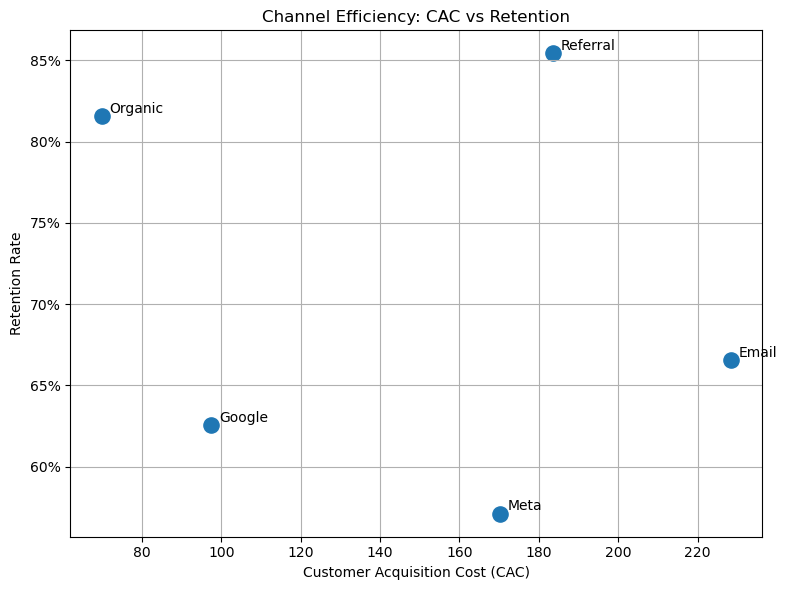

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(8,6))

plt.scatter(df["CAC"], df["retention_rate"], s=120)

for i, row in df.iterrows():
    plt.text(row["CAC"] + 2, row["retention_rate"] + 0.002, row["acquisition_channel"])

plt.xlabel("Customer Acquisition Cost (CAC)")
plt.ylabel("Retention Rate")
plt.title("Channel Efficiency: CAC vs Retention")

plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x:.0%}')

plt.grid(True)
plt.tight_layout()
plt.savefig("cac_vs_retention.png", dpi=300)
plt.show()

